In [1]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"Adding {project_root} to sys.path")

Adding d:\JoshFile\Github\spoofing-recognition\notebooks\training to sys.path


In [3]:
import config

## randomizer

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


## Utils Functions


In [5]:
import copy
import gc 

def train_model(model, device, train_loader, val_loader, criterion, optimizer, epochs, early_stopping_limit=3):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_precision': []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    best_val_precision = 0.0
    early_stopping_counter = 0
    

    for epoch in range(epochs):
        # --- TRAINING PHASE ---
        model.train()
        train_loss = 0.0
        
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
     
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        true_positives = 0
        false_positives = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                true_positives  += ((predicted == 1) & (labels == 1)).sum().item()
                false_positives += ((predicted == 1) & (labels == 0)).sum().item()




        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        if (true_positives + false_positives) > 0:
            val_precision = 100 * true_positives / (true_positives + false_positives)
        else:
            val_precision = 0.0
        
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Precision: {val_precision:.2f}%")

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_precision'].append(val_precision)


   
        if best_val_loss > avg_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0 
            print("  -> New best model saved!")
        else:
            early_stopping_counter += 1 
            print(f"  -> No improvement. Counter: {early_stopping_counter}/{early_stopping_limit}")


        gc.collect()
        if device.type == 'cuda':
            torch.cuda.empty_cache()
            
        if early_stopping_counter >= early_stopping_limit:
            print("Early stopping triggered.")
            break


    model.load_state_dict(best_model_wts)
    return model, history

## Params

In [6]:
BBOX_ORGINAL_SIZE = 224
TARGET_SIZE = 500

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Add Augmentation for Training
train_transform = transforms.Compose([
    transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Keep Validation/Test pure (Resize only)
val_transform = transforms.Compose([
    transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Model


In [7]:
from torchvision import models
import torch.nn as nn

# Load EfficientNet (Pre-trained on 1 million images)
model = models.efficientnet_b6(weights=models.EfficientNet_B6_Weights.DEFAULT)

# freeze layer
for param in model.features.parameters():
    param.requires_grad = False

# Adjust the final layer for 2 classes (Live/Spoof)
# EfficientNet uses .classifier instead of .fc
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)



## Dataloader

In [8]:
import os
import glob
import json
from torch.utils.data import Dataset

from PIL import Image

# class CelebASpoofDataset(Dataset):

    
#     def __init__(self, root_dir, json_label_path, transform=None):
#         """
#         Args:
#             root_dir: Path to the 'data' folder
#             json_label_path: Path to the train_label.json or test_label.json
#             transform: PyTorch transforms
#         """
#         self.root_dir = root_dir
#         self.transform = transform
        
#         # Load the JSON labels
#         with open(json_label_path, 'r', encoding='utf-8') as f:
#             self.label_dict = json.load(f)
            
#         # The JSON keys are the relative paths to the images
#         self.image_keys = list(self.label_dict.keys())

#     def __len__(self):
#         return len(self.image_keys)

#     def __getitem__(self, idx):
#         # 1. Get image path and labels from JSON
#         rel_path = self.image_keys[idx]
#         full_path = os.path.join(self.root_dir, rel_path)
        
#         # Labels from JSON: [43] is the live/spoof index
#         # 1: spoof, 0: live (usually, verify with your data_description)
#         all_labels = self.label_dict[rel_path]
#         label = torch.tensor(all_labels[43]) 

#         # 2. Open Image
#         image = Image.open(full_path).convert("RGB")
#         real_w, real_h = image.size

#         # 3. Handle Bounding Box
#         # Example txt path: data/train/1/live/000184_BB.txt
#         base_path, _ = os.path.splitext(full_path)
#         txt_path = base_path + "_BB.txt"
        
#         if os.path.exists(txt_path):
#             with open(txt_path, 'r', encoding='utf-8') as f:
#                 bbox = list(map(float, f.read().strip().split()))
#                 if len(bbox) >= 4:
#                     # Scaling logic from README
#                     x1 = int(bbox[0] * (real_w / BBOX_ORGINAL_SIZE))
#                     y1 = int(bbox[1] * (real_h / BBOX_ORGINAL_SIZE))
#                     w1 = int(bbox[2] * (real_w / BBOX_ORGINAL_SIZE))
#                     h1 = int(bbox[3] * (real_h / BBOX_ORGINAL_SIZE))
                    
#                     # Crop (left, top, right, bottom)
#                     image = image.crop((x1, y1, x1 + w1, y1 + h1))

#         # 4. Apply Final Resizing and Normalization
#         if self.transform:
#             image = self.transform(image)

#         return image, label
    


class CelebASpoofDataset(Dataset):
    
    def __init__(self, root_dir, json_label_path, bbox_json_path, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        with open(json_label_path, 'r', encoding='utf-8') as f:
            self.label_dict = json.load(f)
            
        print("Loading BBox Cache into RAM...")
        with open(bbox_json_path, 'r', encoding='utf-8') as f:
            self.bbox_dict = json.load(f)
            
        self.image_keys = list(self.label_dict.keys())

    def __len__(self):
        return len(self.image_keys)

    def __getitem__(self, idx):
        rel_path = self.image_keys[idx]
        full_path = os.path.join(self.root_dir, rel_path)
        
        # Get Label
        all_labels = self.label_dict[rel_path]
        label = torch.tensor(all_labels[43]) 

        # Open Image
        image = Image.open(full_path).convert("RGB")
        real_w, real_h = image.size

        bbox = self.bbox_dict.get(rel_path) 

        if bbox is not None and len(bbox) >= 4:
            # Scaling logic
            x1 = int(bbox[0] * (real_w / BBOX_ORGINAL_SIZE))
            y1 = int(bbox[1] * (real_h / BBOX_ORGINAL_SIZE))
            w1 = int(bbox[2] * (real_w / BBOX_ORGINAL_SIZE))
            h1 = int(bbox[3] * (real_h / BBOX_ORGINAL_SIZE))
            
            image = image.crop((x1, y1, x1 + w1, y1 + h1))
        
        # 4. Transform
        if self.transform:
            image = self.transform(image)

        return image, label
    
# class CelebASpoofDataset(Dataset):
#     def __init__(self, root_dir, json_label_path, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
        
#         with open(json_label_path, 'r', encoding='utf-8') as f:
#             self.label_dict = json.load(f)
            
#         self.image_keys = list(self.label_dict.keys())
        
#         # Pre-load bounding boxes to avoid opening text files during training
#         self.bbox_cache = {}
#         print("Pre-loading bounding boxes...")
#         for rel_path in self.image_keys:
#             base_path, _ = os.path.splitext(rel_path)
#             txt_path = os.path.join(self.root_dir, base_path + "_BB.txt")
            
#             if os.path.exists(txt_path):
#                 with open(txt_path, 'r') as f:
#                     bbox = list(map(float, f.read().strip().split()))
#                     if len(bbox) >= 4:
#                         self.bbox_cache[rel_path] = bbox
#         print(f"Loaded {len(self.bbox_cache)} bounding boxes.")

#     def __len__(self):
#         return len(self.image_keys)

#     def __getitem__(self, idx):
#         rel_path = self.image_keys[idx]
#         full_path = os.path.join(self.root_dir, rel_path)
        
#         label = torch.tensor(self.label_dict[rel_path][43]) 
        
#         # Faster to open and immediately convert
#         image = Image.open(full_path).convert("RGB")
        
#         # Use cached bounding box
#         bbox = self.bbox_cache.get(rel_path)
#         if bbox:
#             real_w, real_h = image.size
#             # Scaling logic
#             x1 = int(bbox[0] * (real_w / BBOX_ORGINAL_SIZE))
#             y1 = int(bbox[1] * (real_h / BBOX_ORGINAL_SIZE))
#             w1 = int(bbox[2] * (real_w / BBOX_ORGINAL_SIZE))
#             h1 = int(bbox[3] * (real_h / BBOX_ORGINAL_SIZE))
#             image = image.crop((x1, y1, x1 + w1, y1 + h1))

#         if self.transform:
#             image = self.transform(image)

#         return image, label

## preparation


In [9]:
import multiprocessing

BATCH_SIZE = 32
EPOCHS =100
EARLY_STOPPING_LIMIT = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
bbox_lookup = "../bbox_lookup.json"

num_cpus = multiprocessing.cpu_count()
workers = num_cpus

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TRAIN_JSON,
    transform=train_transform,
    bbox_json_path=bbox_lookup
)

test_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TEST_JSON,
    transform=val_transform,
    bbox_json_path=bbox_lookup
)
device

Loading BBox Cache into RAM...
Loading BBox Cache into RAM...


device(type='cuda')

In [10]:
len(train_ds)

494405

In [11]:
# use only 1000 images for training next 200 for validation

small_ds = torch.utils.data.Subset(train_ds, list(range(12000)))
small_train_ds = torch.utils.data.Subset(small_ds, list(range(0, 10000, 10)))
small_val_ds = torch.utils.data.Subset(small_ds, list(range(10000, 12000, 10)))
len(small_train_ds)

1000

In [12]:
len(small_val_ds)

200

In [13]:
small_test_ds = torch.utils.data.Subset(test_ds, list(range(1,2000,10)))

In [14]:
from torch.utils.data import DataLoader
small_train_loader = DataLoader(small_train_ds, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True
)
small_val_loader = DataLoader(small_val_ds, 
                              batch_size=BATCH_SIZE,
                              shuffle=False
)
small_test_loader = DataLoader(small_test_ds, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False)

In [15]:
sample_img, sample_label = small_train_ds[0]
sample_img.shape, sample_label

(torch.Size([3, 500, 500]), tensor(0))

In [16]:
def checkImage(small_train_ds):
    sample_img, sample_label = small_train_ds
    display_img = sample_img.permute(1, 2, 0)
    display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min())
    plt.imshow(display_img)
    plt.title(f"Label: {'Live' if sample_label == 0 else 'Spoof'}")
    plt.axis('off')
    plt.show()

def checkAllImage(ds: Dataset):
    for i in ds:
        sample_img, sample_label = i
        display_img = sample_img.permute(1, 2, 0)
        display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min())
        plt.imshow(display_img)
        plt.title(f"Label: {'Live' if sample_label == 0 else 'Spoof'}")
        plt.axis('off')
        plt.show()


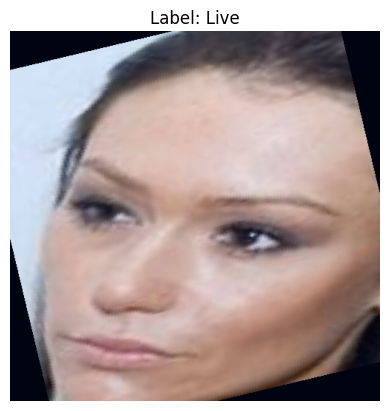

In [17]:
# 1 = spoof  0 = live 
checkImage(small_train_ds[120])

## Train

In [18]:
model, history = train_model(model=model, 
                             device=device, 
                             train_loader=small_train_loader, 
                             val_loader=small_val_loader, 
                             criterion=criterion, 
                             optimizer=optimizer, 
                             epochs=EPOCHS, 
                             early_stopping_limit=EARLY_STOPPING_LIMIT)

Epoch [1/100] Train Loss: 0.6707 | Val Loss: 0.6915 | Val Precision: 79.10%
  -> New best model saved!
Epoch [2/100] Train Loss: 0.6140 | Val Loss: 0.7040 | Val Precision: 79.25%
  -> No improvement. Counter: 1/10
Epoch [3/100] Train Loss: 0.5821 | Val Loss: 0.6724 | Val Precision: 86.11%
  -> New best model saved!
Epoch [4/100] Train Loss: 0.5493 | Val Loss: 0.6310 | Val Precision: 92.08%
  -> New best model saved!
Epoch [5/100] Train Loss: 0.5169 | Val Loss: 0.5691 | Val Precision: 92.91%
  -> New best model saved!
Epoch [6/100] Train Loss: 0.4932 | Val Loss: 0.5205 | Val Precision: 94.12%
  -> New best model saved!
Epoch [7/100] Train Loss: 0.4727 | Val Loss: 0.5049 | Val Precision: 91.85%
  -> New best model saved!
Epoch [8/100] Train Loss: 0.4470 | Val Loss: 0.4730 | Val Precision: 92.03%
  -> New best model saved!
Epoch [9/100] Train Loss: 0.4389 | Val Loss: 0.4340 | Val Precision: 91.84%
  -> New best model saved!
Epoch [10/100] Train Loss: 0.4231 | Val Loss: 0.4338 | Val Precis

C:\Users\Josh\AppData\Local\Temp\ipykernel_22644\4098818283.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
C:\Users\Josh\AppData\Local\Temp\ipykernel_22644\4098818283.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_precision.show()


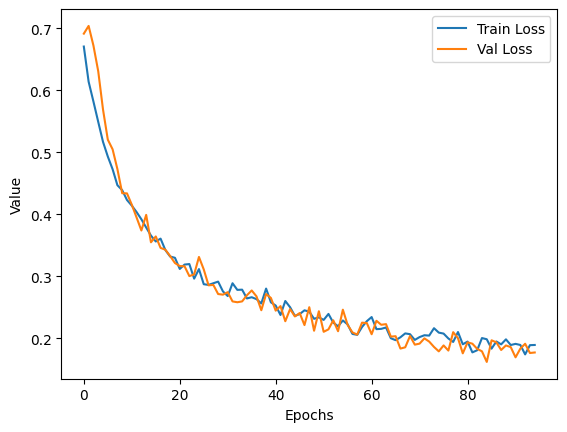

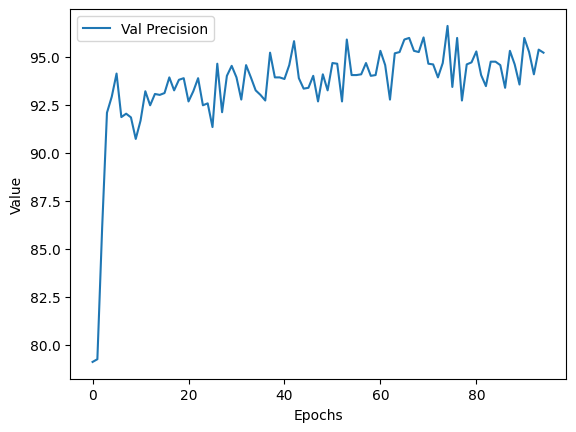

In [19]:
def display_train_result(history):
    fig_loss, ax1 = plt.subplots()
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Value')
    ax1.legend()
    fig_loss.show()

    fig_precision, ax2 = plt.subplots() 
    ax2.plot(history['val_precision'], label='Val Precision')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Value')
    ax2.legend()
    fig_precision.show()

    return fig_loss, fig_precision



train_loss_fig, precision_fig = display_train_result(history)

## test

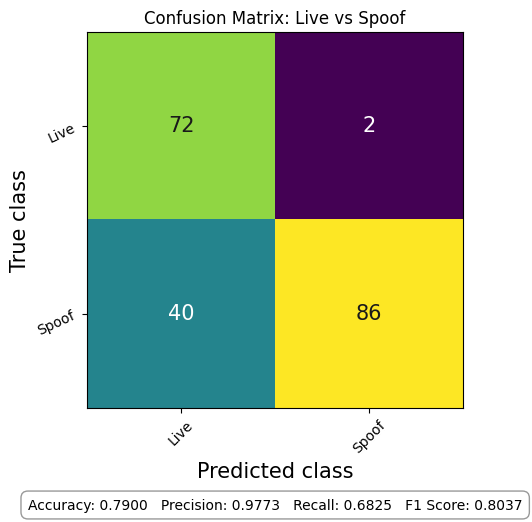

Accuracy: 0.7900
Precision: 0.9773
Recall:    0.6825
F1 Score:  0.8037


In [20]:
from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
def evaluate(model, dataloader, device):
    confmat = MulticlassConfusionMatrix(num_classes=2).to(device)
    accuracy = Accuracy(task="binary").to(device)
    precision = Precision(task="binary").to(device)
    recall = Recall(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Update the metrics with this batch
            confmat.update(preds, labels)
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

    # Compute the final results
    final_matrix = confmat.compute()
    acc_val = accuracy.compute()
    prec_val = precision.compute()
    rec_val = recall.compute()
    f1_val = f1.compute()

    # Plot the matrix
    fig, ax = confmat.plot(labels=["Live", "Spoof"])
    ax.set_title("Confusion Matrix: Live vs Spoof")
    
    # Add metrics as text below the matrix
    metrics_text = (f"Accuracy: {acc_val:.4f}   "
                    f"Precision: {prec_val:.4f}   "
                    f"Recall: {rec_val:.4f}   "
                    f"F1 Score: {f1_val:.4f}")
    
    # Position the text at the bottom center of the figure
    fig.text(0.5, -0.05, metrics_text, ha='center', fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))
    
    plt.show()

    print(f"Accuracy: {acc_val:.4f}")
    print(f"Precision: {prec_val:.4f}")
    print(f"Recall:    {rec_val:.4f}")
    print(f"F1 Score:  {f1_val:.4f}")

    return fig, acc_val, prec_val, rec_val, f1_val

confusion_matrix, accuracy, precision, recall, f1 = evaluate(model=model, dataloader=small_test_loader, device=device)

In [21]:
from pathlib import Path
def create_save_new_path(save_path, path_name, num):
    new_dir = save_path / f"{path_name}_{num}"
    if new_dir.exists():
        return create_save_new_path(save_path, path_name, num + 1)
    else:
        new_dir.mkdir(parents=True)
        return new_dir



def save_results(model, confusion_matrix_fig, train_loss_fig, precision_fig):
    
    save_path = Path("train_results")
    path_name = "train"
    num = 0
    
    save_path.mkdir(parents=True, exist_ok=True)
    
    # create new dir if already exist
    new_path = create_save_new_path(save_path, path_name, num)

    print(f"Saving results to: {new_path}")

    confusion_matrix_fig.savefig(new_path / "confusion_matrix.png", bbox_inches='tight')
    train_loss_fig.savefig(new_path / "train_loss.png")
    precision_fig.savefig(new_path / "precision.png")

    torch.save(model.state_dict(), new_path / "model.pth")
save_results(model=model, confusion_matrix_fig=confusion_matrix, train_loss_fig=train_loss_fig, precision_fig=precision_fig)

Saving results to: train_results\train_2


In [28]:
# check distribution of live and spoof in small_test_ds

def checkDatasetDistribution(dataset):
    live_count = 0
    spoof_count = 0
    for img, label in dataset:
        if label.item() == 0:
            live_count += 1
        else:
            spoof_count += 1
    print(f"Live count: {live_count}, Spoof count: {spoof_count}")
checkDatasetDistribution(small_test_ds)

Live count: 74, Spoof count: 126


In [29]:
checkDatasetDistribution(small_train_ds)

Live count: 311, Spoof count: 689


In [30]:
checkDatasetDistribution(small_val_ds)

Live count: 55, Spoof count: 145
